In [29]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
from matplotlib.ticker import MultipleLocator
from scipy.optimize import minimize


## Define the arbitary tortuosity model

In [14]:
@element(num_params=4,units=["","","","",""],overwrite=True)
def arbitRCPE(p,f):
    Q, alpha, a, b = p[0], p[1], p[2], p[3]
    
    def R(x):
        # return a/(1+b*x)
        return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
    
    def fun(x,y,lmdcos,lmdsin):
        return np.vstack((y[2]*R(x),y[3]*R(x),lmdcos*y[0]-lmdsin*y[1],lmdcos*y[1]+lmdsin*y[0]))

    def bc(ya,yb):
        return np.array([ya[0]-1,yb[2],yb[3],ya[1]])

    x=np.linspace(0,1,1000)
    y=np.zeros((4,x.size))
 
    Z_list=np.zeros((np.size(np.array(f))),dtype=complex)
    ii=0
    for freq in np.array(f):
        w=2*np.pi*freq
        lmdcos=w**alpha*Q*np.cos(alpha*np.pi/2)
        lmdsin=w**alpha*Q*np.sin(alpha*np.pi/2)
        sol1 = solve_bvp(lambda x,y: fun(x,y,lmdcos=lmdcos,lmdsin=lmdsin), bc, x, y)
        y3=sol1.sol(x)[2]
        y4=sol1.sol(x)[3]
        Z=2/(-(y3[0]+y4[0]*1j))
        Z_list[ii]=Z
        ii=ii+1
    return Z_list


## Plot that profile here

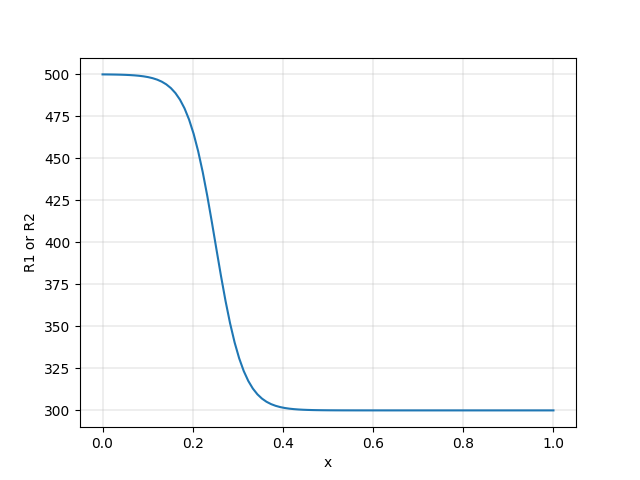

In [48]:
fig1, axx= plt.subplots()
x=np.linspace(0,1,100)
a=4
b=4
def R(x):
    return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
axx.plot(x,R(x))
axx.set_xlabel("x")
axx.set_ylabel("R1 or R2")
axx.grid(linewidth=0.3)

# axx2=axx.twinx()
# axx2.set_ylabel("R1")

# axx.plot([0,0.2063,0.2063,1],[873,873,387,387])

## Find Out the dip angle and the apparent R_ion

6.3027904234987036-1700.7168074839008
intercept: 269.8355320753036
R_ion_app: 404.7532981129554


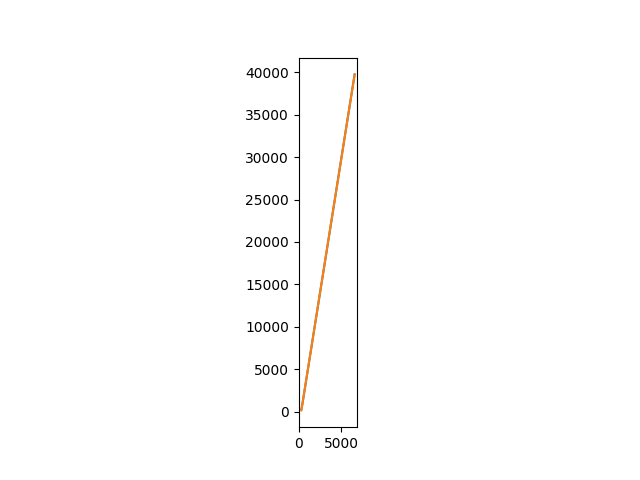

In [47]:
Q=6e-4
alpha=0.9
a=4
b=4
param=[Q,alpha,a,b]
c=CustomCircuit(initial_guess=param,circuit="arbitRCPE")
z=c.predict(frequencies=np.logspace(-2,3,100))
#found the dip angle
dip_angle=alpha*45-np.min(-np.angle(z,deg=True))

#found the Rion by finding the intercept

datax=np.real(z[:int(len(z)/2)])
datay=np.imag(z[:int(len(z)/2)])

ff,ax=plt.subplots()

ax.plot(datax,-datay)
ax.set_aspect("equal")

#actual fitting of a straight line
cp=np.polyfit(datax,-datay,1)
cp[0] 
cp[1] 
print(f"{cp[0]}{cp[1]}")

def y(x,cp):
    return cp[0]*x+cp[1]

ax.plot(datax,y(datax,cp))
R_ion_app=(3/2)*(-cp[1]/cp[0])

print(f"intercept: {-cp[1]/cp[0]}")
print(f"R_ion_app: {R_ion_app}")

In [49]:
import json
file_path = "theta_data_all.json"

with open(file_path, "r") as file:
    json_data = file.read()

theta_list=json.loads(json_data)

In [55]:
def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

#the ratio range for which the theta data is generated
ratio_range=np.linspace(1.2,10,50)

for pf,idx in zip(["Two-step","Linear","Inverse Linear"],[0,1,2]):
    if(pf=="Two-step"):
        R1_by_R2=ratio_range[find_index_of_nearest(theta_list[idx][1],dip_angle)]
        R2_two=2*R_ion_app/(1+R1_by_R2)
        R1_two=R2_two*R1_by_R2
    elif(pf=="Linear"):
        R1_by_R2=ratio_range[find_index_of_nearest(theta_list[idx][1],dip_angle)]
        R2_lin=4*R_ion_app/(1+3*R1_by_R2)
        R1_lin=R2_lin*R1_by_R2
    else:
        R1_by_R2=ratio_range[find_index_of_nearest(theta_list[idx][1],dip_angle)]
        
R1_by_R2

2.4571428571428573

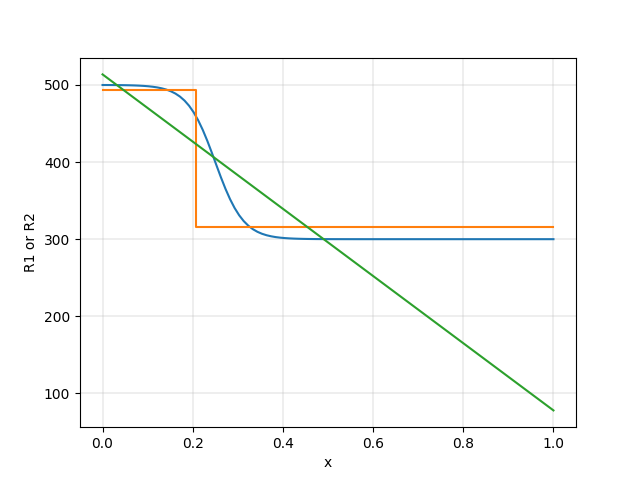

In [57]:
delta=0.2063
fig1, axx= plt.subplots()
x=np.linspace(0,1,100)
a=4
b=4
def R(x):
    return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
#plot the arbitray profile
axx.plot(x,R(x))
#plot the fitted profiles
axx.plot([0,delta,delta,1],[R1_two,R1_two,R2_two,R2_two])
axx.plot([0,1],[R1_lin,R2_lin])
axx.set_xlabel("x")
axx.set_ylabel("R1 or R2")
axx.grid(linewidth=0.3)

## Show the fitted profiles ( two, lin and ilin)

4.268797175965155


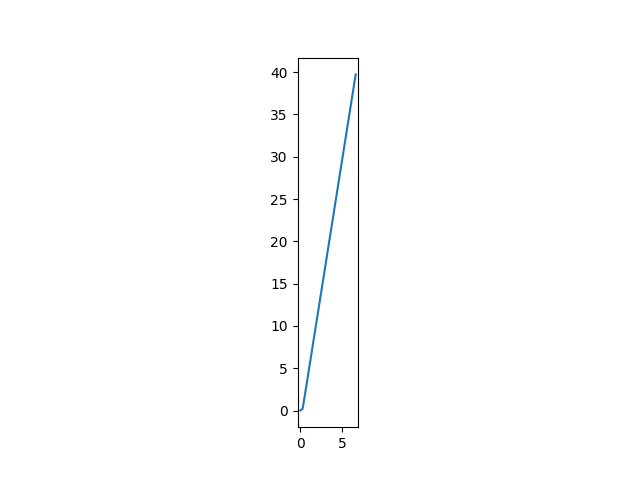

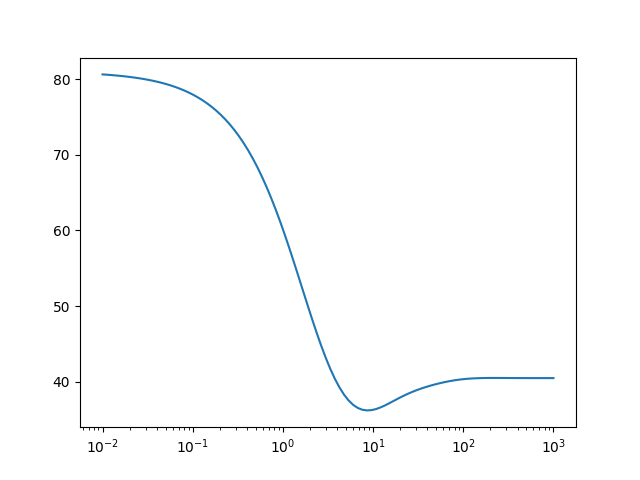

In [60]:
Q=6e-4
alpha=0.9
a=4
b=4
param=[Q,alpha,a,b]
c_arbit=CustomCircuit(initial_guess=param,circuit="arbitRCPE")
# c=CustomCircuit(initial_guess=[6e-4,0.9,4,4],circuit="arbitRCPE")
z_arbir=c_arbit.predict(frequencies=np.logspace(-2,3,100))

c_two=CustomCircuit(initial_guess=,circuit=)

fig, ax=plt.subplots()
ax.plot(np.real(z)/1000,-np.imag(z)/1000)
ax.set_aspect("equal")
# ax.xaxis.set_minor_locator(MultipleLocator(0.1))
# ax.grid(True)

fig2, ax2=plt.subplots()
ax2.plot(np.logspace(-2,3,100),-np.angle(z,deg=True))
# axx.yaxis.set_minor_locator(MultipleLocator(0.5))
ax2.set_xscale("log")
# ax2.grid(True)

print(0.9*45-np.min(-np.angle(z,deg=True)))